# YOLO-LIKE ARCHITECTURE FINAL

## install needed

In [ ]:
!pip install ultralytics opencv-python matplotlib roboflow

## get dataset from roboflow

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="kllPn6XsBsLz8K2iQx6i")
project = rf.workspace("deep-learning-rp9gw").project("final-proj-jpjtg")
version = project.version(3)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...


## import needed

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, f1_score, accuracy_score
from tensorflow.keras.utils import Sequence
from tensorflow.keras import layers, models, optimizers
import datetime
import time

## configuration and mapping

In [ ]:
image_size = (120, 120)  # Keep this to avoid RAM crash
batch_size = 8
epochs = 50


image_dir = "/content/final-proj-3/train/images"
label_dir = "/content/final-proj-3/train/labels"

class_names = ['glass', 'leaf', 'metal', 'paper', 'plastic']
num_classes = len(class_names)

waste_category = {
    "glass": ("non-biodegradable", "recyclable"),
    "leaf": ("biodegradable", "non-recyclable"),
    "metal": ("non-biodegradable", "recyclable"),
    "paper": ("biodegradable", "recyclable"),
    "plastic": ("non-biodegradable", "recyclable"),
}

## data augmentation function

In [ ]:
def augment_image(image):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.1)  # brightness augmentation
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    image = tf.image.random_saturation(image, lower=0.9, upper=1.1)
    return image

## data generator

In [ ]:
class WasteDataGenerator(Sequence):
    def __init__(self, image_filenames, batch_size, image_size, augment=False, shuffle=True):
        self.image_filenames = image_filenames
        self.batch_size = batch_size
        self.image_size = image_size
        self.augment = augment
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.image_filenames)

    def __getitem__(self, index):
        batch_files = self.image_filenames[index * self.batch_size:(index + 1) * self.batch_size]
        X = []
        y_class = []
        y_bbox = []

        for fname in batch_files:
            img_path = os.path.join(image_dir, fname)
            label_path = os.path.join(label_dir, os.path.splitext(fname)[0] + ".txt")

            if not os.path.exists(img_path) or not os.path.exists(label_path):
                continue

            img = cv2.imread(img_path)
            if img is None:
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, self.image_size)
            img = img / 255.0

            if self.augment:
                img = augment_image(tf.convert_to_tensor(img))
                img = tf.clip_by_value(img, 0.0, 1.0).numpy()  # Clip after augmentation

            with open(label_path, 'r') as f:
                line = f.readline().strip().split()
                if len(line) != 5:
                    continue
                cls_id = int(line[0])
                bbox = list(map(float, line[1:]))

            X.append(img)
            y_class.append(tf.keras.utils.to_categorical(cls_id, num_classes=num_classes))
            y_bbox.append(bbox)

        return np.array(X), {"class_output": np.array(y_class), "bbox_output": np.array(y_bbox)}

## loading file names

In [ ]:
all_filenames = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.png'))]
random.shuffle(all_filenames)

split1 = int(len(all_filenames)*0.8)
split2 = int(len(all_filenames)*0.9)

train_files = all_filenames[:split1]
val_files = all_filenames[split1:split2]
test_files = all_filenames[split2:]

train_gen = WasteDataGenerator(train_files, batch_size, image_size, augment=True, shuffle=True)
val_gen = WasteDataGenerator(val_files, batch_size, image_size, augment=False, shuffle=False)
test_gen = WasteDataGenerator(test_files, batch_size, image_size, augment=False, shuffle=False)

## making of yolo-like model

In [ ]:
def build_yolo_model():
    inputs = layers.Input(shape=(image_size[0], image_size[1], 3))

    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(256, (3,3), activation='relu', padding='same')(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)

    class_output = layers.Dense(num_classes, activation='softmax', name='class_output')(x)
    bbox_output = layers.Dense(4, activation='sigmoid', name='bbox_output')(x)

    model = models.Model(inputs=inputs, outputs=[class_output, bbox_output])
    model.compile(
        optimizer=optimizers.Adam(learning_rate=0.001),
        loss={'class_output': 'categorical_crossentropy', 'bbox_output': 'mse'},
        metrics={'class_output': 'accuracy'}
    )
    return model

model = build_yolo_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 120, 120,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 60, 60,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 60, 60,    │     18,496 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 30, 30,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 30, 30,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 15, 15,    │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 15, 15,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ conv2d_7[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class_output        │ (None, 5)         │      1,285 │ dense_1[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bbox_output (Dense) │ (None, 4)         │      1,028 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 456,521 (1.74 MB)

 Trainable params: 456,521 (1.74 MB)

 Non-trainable params: 0 (0.00 B)

## callbacks

In [ ]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint("best_yolo_model.keras", save_best_only=True, monitor="val_class_output_accuracy", mode="max")
earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor="val_class_output_accuracy", patience=5, restore_best_weights=True, mode="max")

# training logs
class TrainingLogger(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.start_time = time.time()
        self.logs = []

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start = time.time()

    def on_epoch_end(self, epoch, logs=None):
        epoch_time = time.time() - self.epoch_start
        log_str = (f"Epoch {epoch + 1}/{epochs} - "
                   f"Time: {epoch_time:.2f}s - "
                   f"Loss: {logs['loss']:.4f} - "
                   f"Class Accuracy: {logs['class_output_accuracy']:.4f} - "
                   f"Val Loss: {logs['val_loss']:.4f} - "
                   f"Val Class Accuracy: {logs['val_class_output_accuracy']:.4f}\n")
        self.logs.append(log_str)
        with open("training_logs.txt", "a") as f:
            f.write(log_str)

training_logger = TrainingLogger()

## model training

In [ ]:
history = model.fit(
    train_gen,
    epochs=epochs,
    validation_data=val_gen,
    callbacks=[tensorboard_callback, checkpoint_callback, earlystop_callback, training_logger],
    verbose=1
)

Epoch 1/50
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 388s 332ms/step - bbox_output_loss: 0.0296 - class_output_accuracy: 0.4268 - class_output_loss: 1.3306 - loss: 1.3601 - val_bbox_output_loss: 0.0206 - val_class_output_accuracy: 0.6259 - val_class_output_loss: 0.8912 - val_loss: 0.9104
Epoch 2/50
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 367s 319ms/step - bbox_output_loss: 0.0204 - class_output_accuracy: 0.6432 - class_output_loss: 0.8902 - loss: 0.9105 - val_bbox_output_loss: 0.0201 - val_class_output_accuracy: 0.6958 - val_class_output_loss: 0.7595 - val_loss: 0.7779
Epoch 3/50
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 356s 310ms/step - bbox_output_loss: 0.0186 - class_output_accuracy: 0.6812 - class_output_loss: 0.7803 - loss: 0.7990 - val_bbox_output_loss: 0.0188 - val_class_output_accuracy: 0.6827 - val_class_output_loss: 0.7397 - val_loss: 0.7577
Epoch 4/50
1148/1148 ━━━━━━━━━━━━━━━━━━━━ 363s 316ms/step - bbox_output_loss: 0.0175 - class_output_accuracy: 0.7251 - class_output_loss: 0.6874 - loss: 0.7047 - val_

## model evaluation

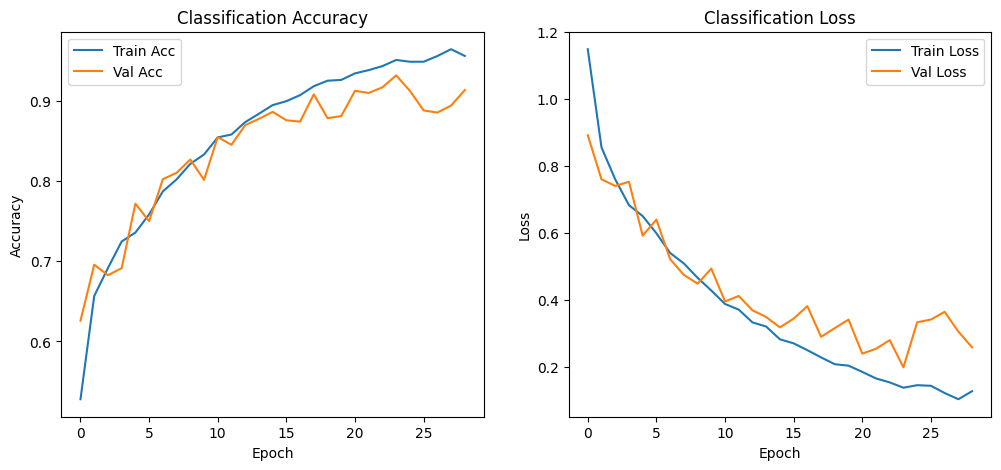

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['class_output_accuracy'], label='Train Acc')
plt.plot(history.history['val_class_output_accuracy'], label='Val Acc')
plt.title('Classification Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['class_output_loss'], label='Train Loss')
plt.plot(history.history['val_class_output_loss'], label='Val Loss')
plt.title('Classification Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## classification report

In [ ]:
X_test = []
y_cls_test = []
y_bbox_test = []

for i in range(len(test_gen)):
    X_batch, y_batch = test_gen[i]
    X_test.append(X_batch)
    y_cls_test.append(y_batch['class_output'])
    y_bbox_test.append(y_batch['bbox_output'])

X_test = np.vstack(X_test)
y_cls_test = np.vstack(y_cls_test)
y_bbox_test = np.vstack(y_bbox_test)

pred_class_probs, pred_bbox = model.predict(X_test)
y_true = np.argmax(y_cls_test, axis=1)
y_pred = np.argmax(pred_class_probs, axis=1)

print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))
print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print(f"F1 Score (weighted): {f1_score(y_true, y_pred, average='weighted'):.4f}")

36/36 ━━━━━━━━━━━━━━━━━━━━ 12s 317ms/step
Classification Report:
               precision    recall  f1-score   support

       glass       0.84      0.91      0.87       137
        leaf       1.00      1.00      1.00       261
       metal       0.96      0.90      0.93       262
       paper       0.94      0.97      0.96       243
     plastic       0.93      0.91      0.92       244

    accuracy                           0.94      1147
   macro avg       0.93      0.94      0.93      1147
weighted avg       0.94      0.94      0.94      1147

Accuracy: 0.9407
F1 Score (weighted): 0.9408


## heatmap result of 10 random images

Using last conv layer: conv2d_7


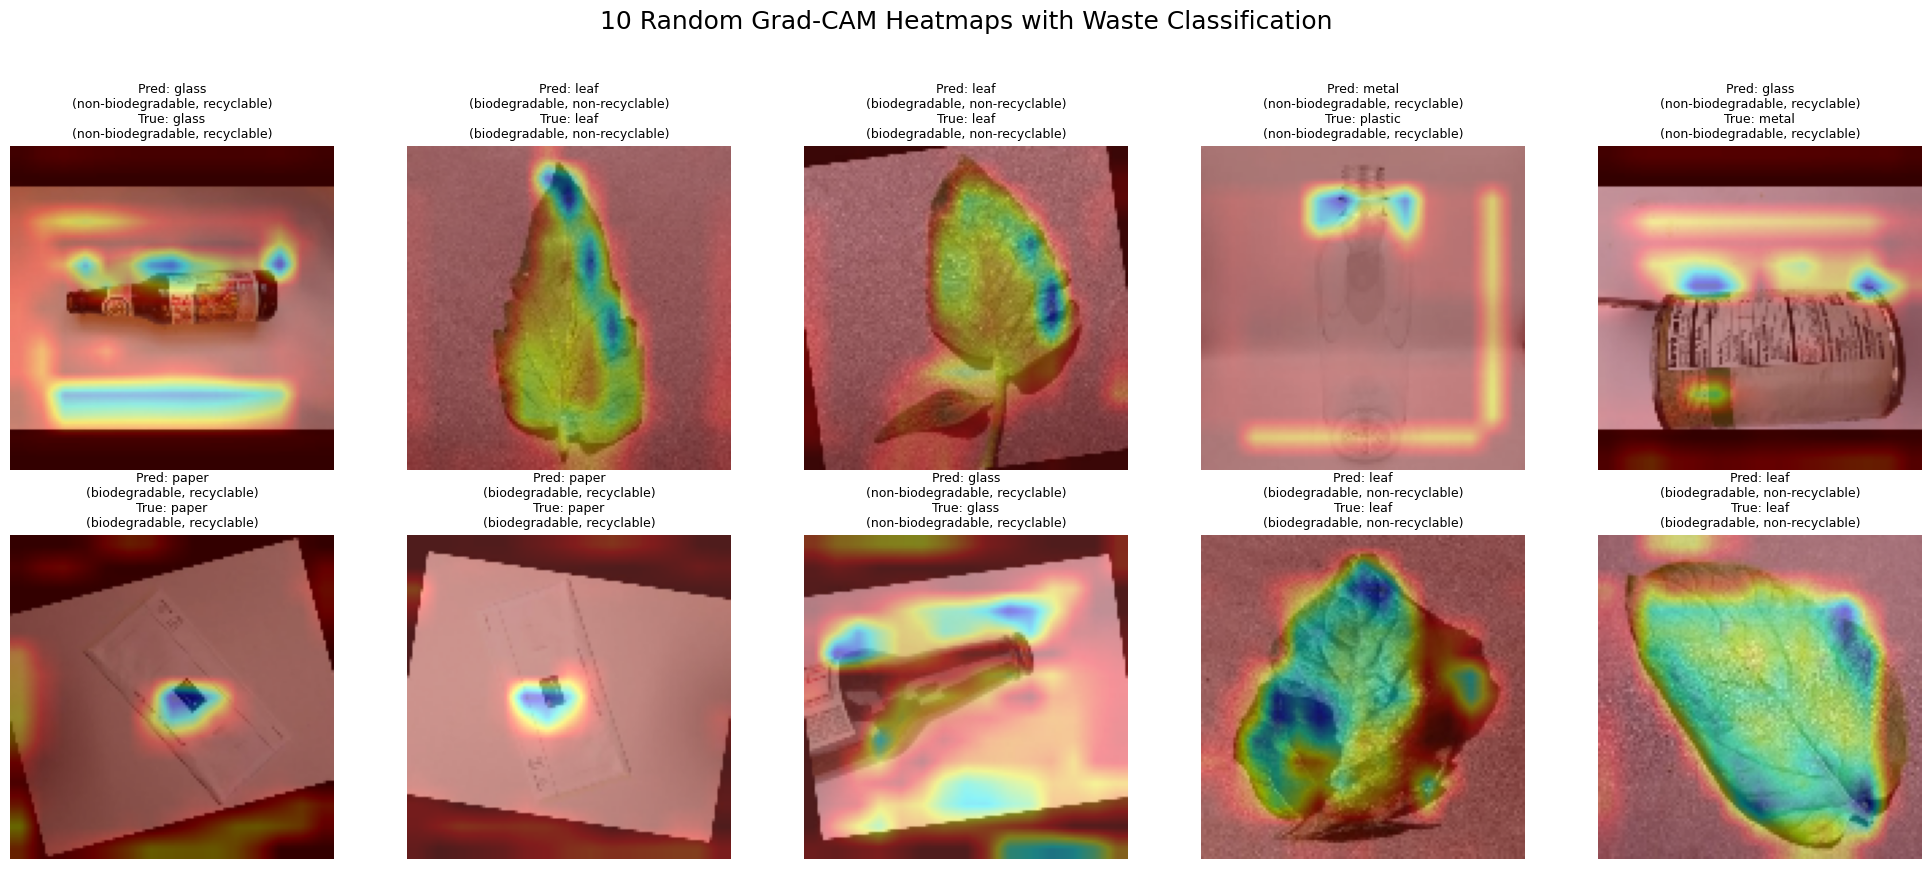

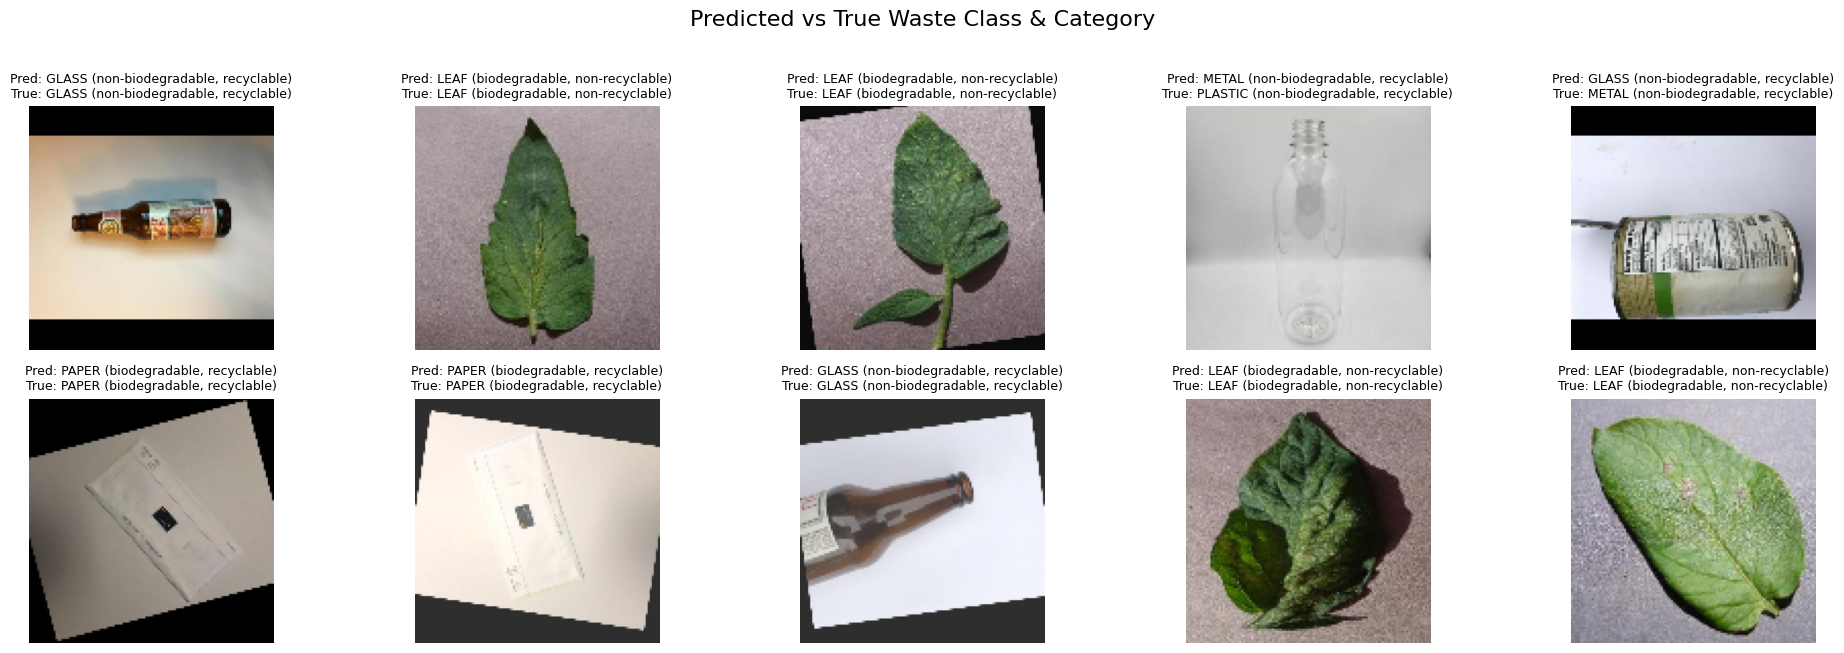

In [ ]:
from tensorflow.keras.models import Model

def find_last_conv_layer(model):
    # Go through layers in reverse order
    for layer in reversed(model.layers):
        if isinstance(layer, layers.Conv2D):
            return layer.name
    raise ValueError("No Conv2D layer found in the model.")

def make_gradcam_heatmap(img_array, model, class_index, last_conv_layer_name):
    grad_model = Model(
        [model.inputs],
        [model.get_layer(last_conv_layer_name).output, model.output[0]]
    )

    img_array = np.expand_dims(img_array, axis=0)

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2)).numpy()
    conv_outputs = conv_outputs[0].numpy()

    for i in range(pooled_grads.shape[-1]):
        conv_outputs[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_outputs, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1
    return heatmap

# === Show Grad-CAM heatmaps for 10 random test images ===
true_class_indices = np.argmax(y_cls_test, axis=1)
indices = random.sample(range(len(X_test)), 10)
last_conv_layer_name = find_last_conv_layer(model)
print(f"Using last conv layer: {last_conv_layer_name}")

plt.figure(figsize=(20, 8))  # 2 rows × 5 columns

for i, idx in enumerate(indices):
    img = X_test[idx]
    true_cls_index = true_class_indices[idx]
    true_cls_name = class_names[true_cls_index]

    # Predict
    pred = model.predict(np.expand_dims(img, axis=0), verbose=0)
    pred_cls_index = np.argmax(pred[0])
    pred_cls_name = class_names[pred_cls_index]

    # Waste categories
    pred_cat = waste_category.get(pred_cls_name, ("unknown", "unknown"))
    true_cat = waste_category.get(true_cls_name, ("unknown", "unknown"))

    heatmap = make_gradcam_heatmap(img, model, pred_cls_index, last_conv_layer_name)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    img_uint8 = np.uint8(255 * img)
    superimposed_img = cv2.addWeighted(img_uint8, 0.6, heatmap_color, 0.4, 0)

    plt.subplot(2, 5, i + 1)
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.title(
        f"Pred: {pred_cls_name}\n({pred_cat[0]}, {pred_cat[1]})\n"
        f"True: {true_cls_name}\n({true_cat[0]}, {true_cat[1]})",
        fontsize=9
    )

plt.tight_layout()
plt.suptitle("10 Random Grad-CAM Heatmaps with Waste Classification", fontsize=18, y=1.08)
plt.show()

plt.figure(figsize=(20, 6))

for i, idx in enumerate(indices):
    img = X_test[idx]

    # True class and category
    true_cls_index = true_class_indices[idx]
    true_class_name = class_names[true_cls_index]
    true_cat = waste_category.get(true_class_name, ("unknown", "unknown"))

    # Predicted class and category
    pred = model.predict(np.expand_dims(img, axis=0), verbose=0)
    pred_cls_index = np.argmax(pred[0])
    pred_class_name = class_names[pred_cls_index]
    pred_cat = waste_category.get(pred_class_name, ("unknown", "unknown"))

    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(
        f"Pred: {pred_class_name.upper()} ({pred_cat[0]}, {pred_cat[1]})\n"
        f"True: {true_class_name.upper()} ({true_cat[0]}, {true_cat[1]})",
        fontsize=9
    )

plt.tight_layout()
plt.suptitle("Predicted vs True Waste Class & Category", fontsize=16, y=1.08)
plt.show()
